# Libraries

In [1]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import argparse
import time
import cv2
import os
import torch 
import torch.nn as nn
from torch.autograd import Variable
from darknet import Darknet
from preprocess import prep_image, inp_to_image
from util import *

# Initialize The YOLOv3 Model

In [2]:
# Loading pre-trained YOLOv3 model weights
print("Loading weights.....")
model = Darknet('cfg/yolov3-tiny.cfg')
model.load_weights('yolov3-tiny.weights')
print("Weights successfully loaded")

Loading weights.....
Weights successfully loaded


In [3]:
# Default Parameter for model
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
num_classes = 80
classes = load_classes('data/coco.names')

In [4]:
# Set image height and check the model
model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

In [5]:
#Set the model in evaluation mode
_ = model.eval()

# Functions For Object Detection

In [6]:
# Draw boxes and label on image
def annotate(x, img):
    """ Returns image with rectangle on result"""
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = (33, 255, 33)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img

In [7]:
# Detect object with YOLOv3 model
def detect(image='./imgs/person.jpg'):
    """ Return image with rectangles and label at detected object """
    prep = prep_image(image, inp_dim)
    im_batch = prep[0]
    orgin_image = prep[1]
    im_dim_list = torch.FloatTensor(prep[2]).repeat(1,2)

    with torch.no_grad():
        prediction = model(Variable(im_batch), False)

    prediction = write_results(prediction, confidence, num_classes, nms = True, nms_conf = nms_thesh)
    output = prediction

    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())    
    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)

    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2    
    output[:,1:5] /= scaling_factor

    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

    list(map(lambda x: annotate(x, orgin_image), output))

    return orgin_image
    

# Model Testing

In [8]:
# Set image file location
image = './imgs/person.jpg'

In [9]:
# Perform a detection with image
result = detect(image)

In [10]:
# Write to image file
cv2.imwrite('result.jpg', result)

True

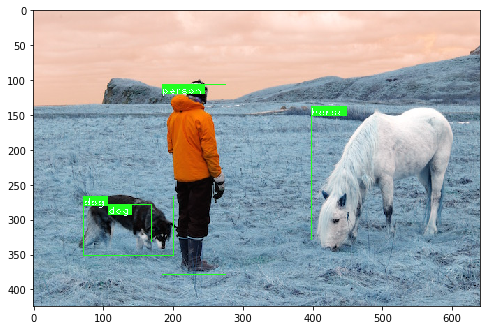

In [11]:
# Show to cell with plt
plt.figure(figsize=(8,8))
_ = plt.imshow(result)

# Further Improvements

Arguments:
* image : The path to the input image. We’ll detect objects in this image using YOLO.
* yolo : The base path to the YOLO directory. Our script will then load the required YOLO files in order to perform object detection on the image.
* confidence : Minimum probability to filter weak detections. We have given this a default value of 50% ( 0.5 ), but you should feel free to experiment with this value.
* threshold : This is our non-maxima suppression threshold with a default value of 0.3 . 

In [12]:
# construct the arguments
args = {'image': 'imgs/baggage_claim.jpg', 'yolo': 'yolo-coco', 'confidence': 0.5, 'threshold': 0.3}

In [13]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

In [14]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

Here we load all of our class *LABELS* and random COLORS  are then assigned to each label.

Let’s derive the paths to the YOLO weights and configuration files followed by loading YOLO from disk:

In [15]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

To load YOLO from disk, we’ll take advantage of OpenCV’s DNN function called cv2.dnn.readNetFromDarknet . This function requires both a configPath  and weightsPath  which are established via the given dictionary objects.

Let’s load the image and send it through the network:

In [16]:
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


* Load the input image  and extract its dimensions.
* Determine the output layer names from the YOLO model.
* Construct a blob  from the image 

Now that our blob is prepared, We’ll perform a forward pass through our YOLO network and show the inference time for YOLO.

In [17]:
# load our input image and grab its spatial dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

In [18]:

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [19]:

# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))


[INFO] YOLO took 0.571175 seconds


Bounding Box Detection List:
    
* Boxes : Our bounding boxes around the object.
* Confidences : The confidence value that YOLO assigns to an object. Lower confidence values indicate that the object might not be what the network thinks it is. Remember from our command line arguments above that we’ll filter out objects that don’t meet the 0.5  threshold.
* ClassIDs : The detected object’s class label.


In [20]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

After, we:
* Loop over each of the layerOutputs.
* Loop over each detection in output.
* Extract the classID and confidence.
* Use the confidence to filter out weak detections.

Once we have filtered out unwanted detections, we are going to:
* Scale bounding box coordinates so we can display them properly on our original image.
* Extract coordinates and dimensions of the bounding box. YOLO returns bounding box coordinates in the form: (centerX, centerY, width, and height) .
* Use this information to derive the top-left (x, y)-coordinates of the bounding box.
* Update the boxes , confidences , and classIDs  lists.


In [21]:
# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability) of
        # the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > args["confidence"]:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],args["threshold"])



In [22]:
# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)


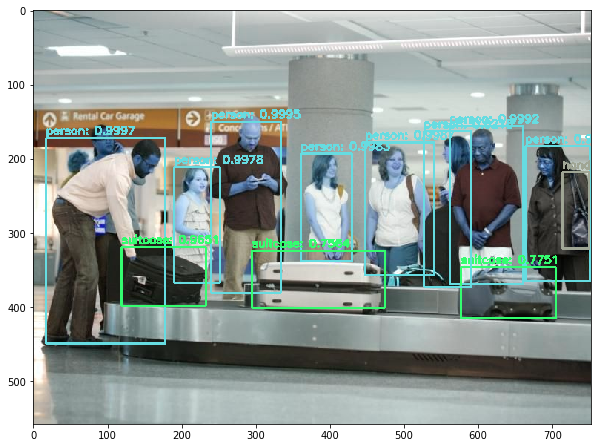

In [23]:
# Show to cell with plt
plt.figure(figsize=(10,10))
_ = plt.imshow(image)

In [ ]:
# show the output image
cv2.imshow("Image", image)
cv2.waitKey(0)